# How to use the Irspec2d script

The test data is in the `testdata` folder.  
It's for the DAR molecule calculated with a def2-TZVP basis set and the b3-lyp functional.  
The hetero-hydrogen atoms were deuterated and its calculated in D2O using COSMO.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/julia/2d-ir-spectroscopy/src')
sys.path.append('/home/julia/2d-ir-spectroscopy/src/Irspec2d/')
from Irspec2d import * 

plt.rc('font', size=20)
plt.rcParams['lines.linewidth'] = 1

## 2D-IR Base Class

The instance always requires frequencies and transition dipole moments as an input. 

```python
class Calc2dir_base():
    def __init__(self, freqs : np.ndarray, dipoles : np.ndarray):
        ...
```

- The `Calc2dir_base()` class removes additional dimensions the transition dipole moment matrices, which are provided by the anharmonic calculations using LocVib and Vibrations in a (n,n,1,3) shape, where n are the number of oscillators in the calculations. It sets them to `self.dipoles`.
- If the frequencies are also given as a matrix (as given by LocVib/Vibrations output), it sets the `self.freqs` to the first row of the input frequencies, otherwise sets the input as is to `self.freqs`.
- It checks if the length of the frequency and dipole moment inputs are equal.
- It checks if the transition dipole moment matrix is (skew-)symmetrical. 
- It sets the number of oscillators to `self.noscill`.

In [2]:
# load data
VCI_freq = np.load('testdata/VCI_frequencies.npy')
VCI_dipo = np.load('testdata/VCI_dipolemoments.npy')
VCI_ints = np.load('testdata/VCI_intensities.npy')

VCI_freq_h = np.load('testdata/VCI_frequencies_harm.npy')
VCI_dipo_h = np.load('testdata/VCI_dipolemoments_harm.npy')
VCI_ints_h = np.load('testdata/VCI_intensities_harm.npy')

EXC_cmat = np.load('testdata/Exciton_cmat_lm.npy')
EXC_dipo = np.load('testdata/Exciton_dipolemoments_lm.npy')

If the intensities are not given, one can use 
```python
def calc_trans2int():
    (...)
    return intenmat
```
from the Calc2dir_base class in order to calculate the intensity matrix from the given transition dipole moment matrix.  
Use it like this:
```python
calc_ints = Calc2dir_base(frequencies, dipolemoments).calc_trans2int()
```

-----------------
## 1D-IR Spectra and Spectra Class

The `spectra` class is a collection of useful functions for plotting spectra.  
It contains only static functions and therefore does not inherit the base class. 

- Set the number of displayed lines in a matplotlib.pyplot contour plot by using 
```python 
spectra.set_line_spacing(maximum, number)
``` 
Where `maximum` is the maximum of the two-dimensional function and `number` is the number of displayed lines.

- It includes a gaussian type function `gauss_func(x,gamma)` and its two-dimensional variant `gauss2d_func`
- It includes a lorentzian type function `lorentz_func`, its imaginary part `lorentz_func_imag` and the two-dimensional variants `lorentzian2D` and `lorentzian2D_imag`.
- It includes 
```python
def get_1d_spectrum(xmin,xmax,freqs,ints,steps=5000,gamma=2,ftype='lorentz'):
    (...)
    return x,y
```
which computes the x and y values for 1D spectra. One can chose between gaussian `gauss` and lorentzian `lorentz` functions.  
As input, one-dimensional data for frequencies `freqs` and intensities `ints` are needed. 

In [3]:
# Get 1D spectra from anharmonic data for both kinds of function.
x_1d_g,y_1d_g = spectra.get_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='gauss')
y_1d_g = y_1d_g/y_1d_g.max() # Set the highest value to one.
x_1d_l,y_1d_l = spectra.get_1d_spectrum(2000,2200,VCI_freq[0],VCI_ints[0],ftype='lorentz')
y_1d_l = y_1d_l/y_1d_l.max()

# Get 1D spectra from harmonic data for both kinds of function.
x_1d_g_h,y_1d_g_h = spectra.get_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='gauss')
y_1d_g_h = y_1d_g_h/y_1d_g_h.max()
x_1d_l_h,y_1d_l_h = spectra.get_1d_spectrum(2000,2200,VCI_freq_h[0],VCI_ints_h[0],ftype='lorentz')
y_1d_l_h = y_1d_l_h/y_1d_l_h.max()

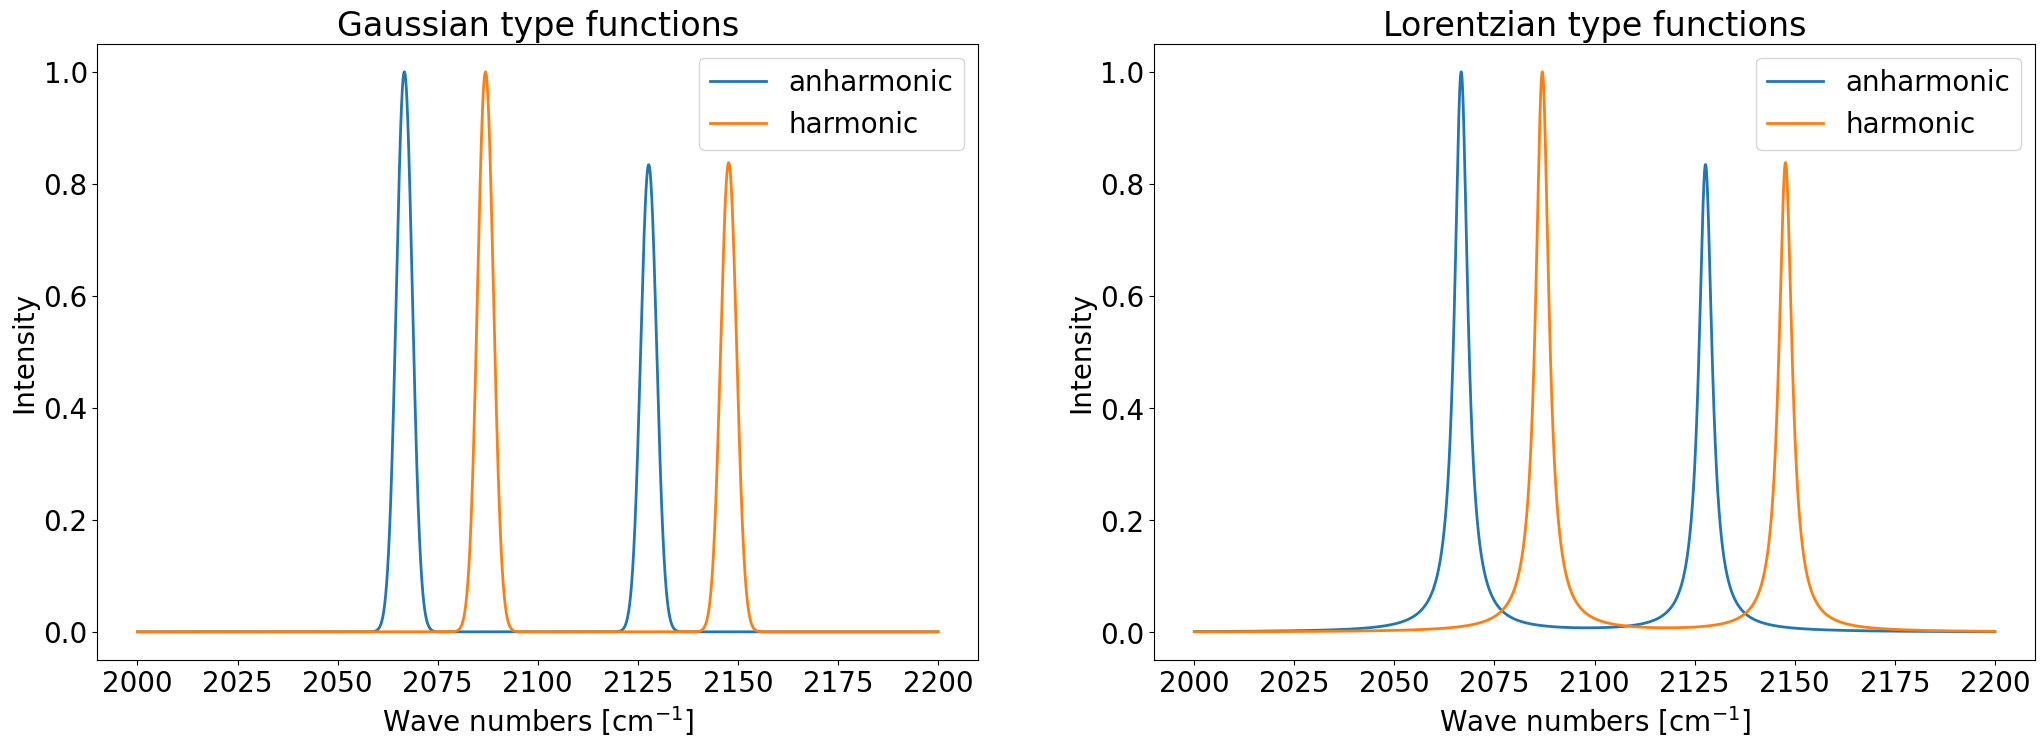

In [4]:
# Plot a comparison between both kinds of functions.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))

ax1.plot(x_1d_g, y_1d_g,label='anharmonic', linewidth=2)
ax2.plot(x_1d_l, y_1d_l,label='anharmonic', linewidth=2)

ax1.plot(x_1d_g_h, y_1d_g_h,label='harmonic', linewidth=2)
ax2.plot(x_1d_l_h, y_1d_l_h,label='harmonic', linewidth=2)

ax1.set_title('Gaussian type functions')
ax2.set_title('Lorentzian type functions')

ax1.set_ylabel('Intensity')
ax1.set_xlabel('Wave numbers [cm$^{-1}$]')
ax2.set_ylabel('Intensity')
ax2.set_xlabel('Wave numbers [cm$^{-1}$]')

ax1.legend()
ax2.legend()

plt.show()

-------------------
## Frequency Domain  Class

The `frequencydomain` class inherits the `Calc2dir_base` class.  
It also needs frequencies and dipole moments as input parameters. 


There are three processes that can happen: Excited State Absorption, Stimulated Emission and Ground State Bleach.  
Each of them can be calculated by a function as tuples:
```python
def calc_excitation(self,intmat):
    (...)
    return (exc_x, exc_y, exc_i)

def calc_stimulatedemission(self,intmat):
    (...)
    return (emi_x, emi_y, emi_i)

def calc_bleaching(self,intmat):
    (...)
    return (ble_x, ble_y, ble_i)
```
In order to compute all of them at once, there is
```python
def calc_all_2d_process(self):
    (...)
    return exc, ste, ble
```

This leads to x- and y-coordinates of the differnt peaks with their respective intensities.  

In [5]:
freqdom = frequencydomain(VCI_freq[0],VCI_dipo,T2=0.3)
exc,emi,ble = freqdom.calc_all_2d_process()

Prints all output (default). To suppress printed output use frequencydomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 256 (default value).
Set the dephasing time (T2) to 0.3 ps.
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).


Now, there are functions fittet on top of these peaks - analogous to the 1D spectra seen before one can chose between gauss and lorentz functions.  
They can also be normalized, so that the highest peak has the intensity = 1.
```python
def _get_2d_spectrum(xmin,xmax,steps=2000,halfwidth=5,ftype='lorentz'):
    (...)
    return x, z
```

In [6]:
dim = 500
min_fd = 2000
max_fd = 2200

x_2d_g, z_2d_g = freqdom._get_2d_spectrum(min_fd, max_fd, steps=dim, gamma=2.5, ftype='gauss')
z_2d_g = z_2d_g/z_2d_g.max()

x_2d_l, z_2d_l = freqdom._get_2d_spectrum(min_fd, max_fd, steps=dim, gamma=2.5, ftype='lorentz')
z_2d_l = z_2d_l/z_2d_l.max()

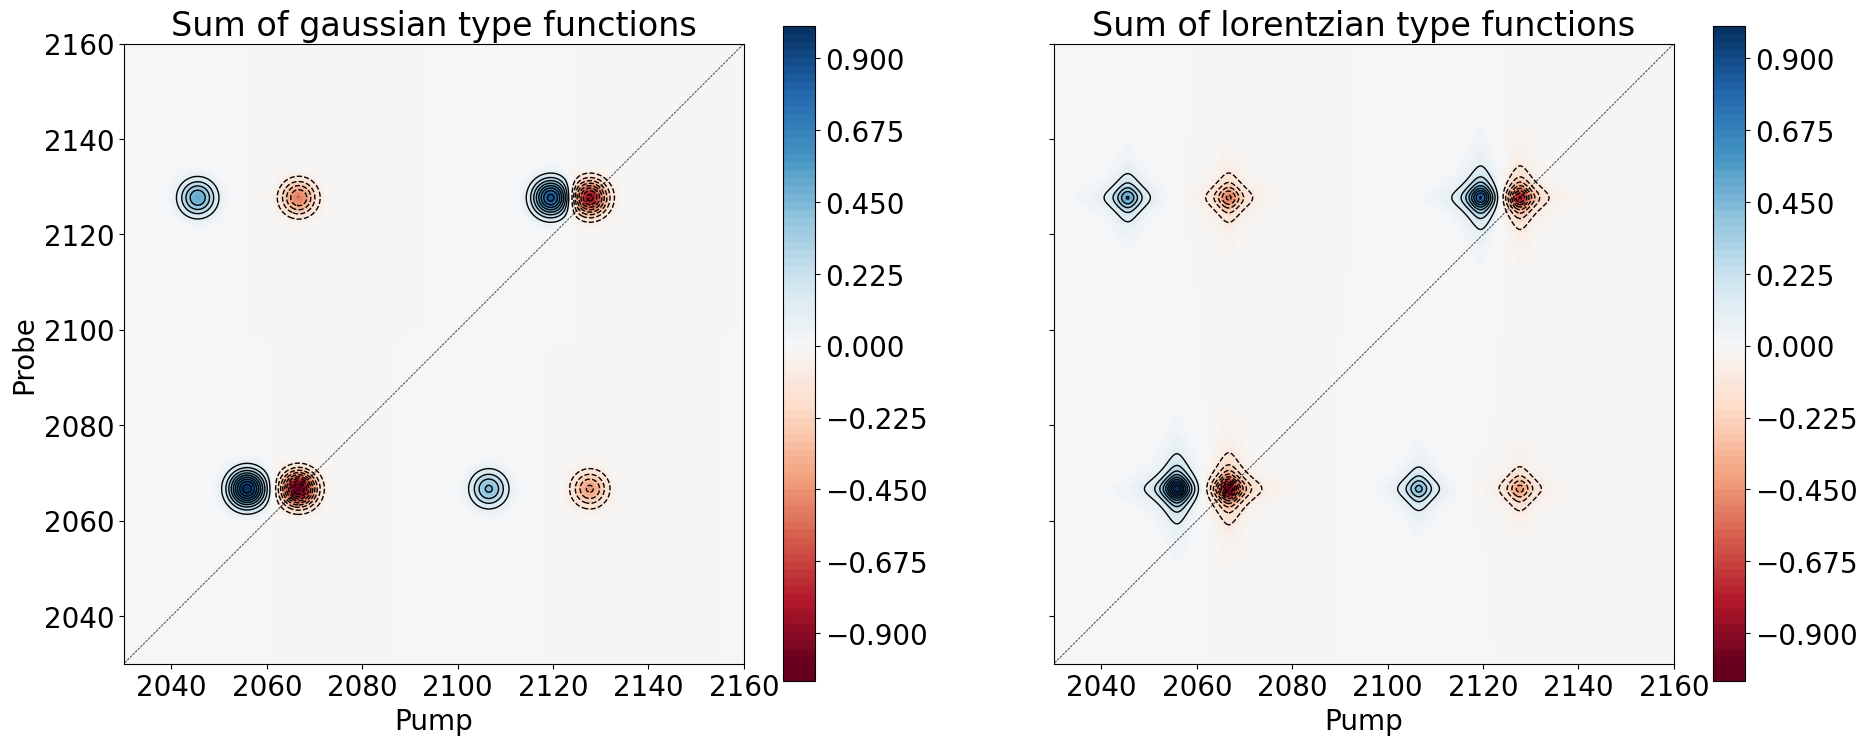

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(22,10))

ax1.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)
ax2.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0", linewidth=0.5)

im1 = ax1.contourf(x_2d_g,x_2d_g,z_2d_g, 100, alpha=1, cmap='RdBu', vmax=1, vmin=-1)
im2 = ax2.contourf(x_2d_l,x_2d_l,z_2d_l, 100, alpha=1, cmap='RdBu', vmax=1, vmin=-1)

ax1.contour(x_2d_g,x_2d_g,z_2d_g,spectra.set_line_spacing(abs(z_2d_g).max(),10),colors='k')
ax2.contour(x_2d_l,x_2d_l,z_2d_l,spectra.set_line_spacing(abs(z_2d_l).max(),10),colors='k')

ax1.set_title('Sum of gaussian type functions')
ax2.set_title('Sum of lorentzian type functions')

ax1.set_ylabel('Probe')
ax1.set_xlabel('Pump')
ax2.set_xlabel('Pump')

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

ax1.set_xlim(2030,2160)
ax1.set_ylim(2030,2160)

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

The `frequencydomain` class can also compute more advanced 2D-IR spectra by using the four-point correlation function, which includes polarization effects. 

```python
frequencydomain(frequencies,dipolemoments,n_t=n_t,T2=T2,pol=pol,pol_list=pol_list,print_output=True)
```

It includes further parameters, that can be set:
- `n_t` : number of time points (grid)
- `T2` : dephasing time
- `pol` : polarization condition, e.g. 'ZZZZ' or 'ZZXX'
- `pol_list` : polarization condition angles, e.g. [0,0,0,0] or [0,0,90,90]

If none are given, the calculation automatically choses standard values.


The signal
```python
def calculate_S(w):
    ...
    return S_GB, S_SE, S_EA
```
function is written in analogy to the time domain calculations (shown below).  
The resulting spectrum is then generated by
```python
def get_2d_spectrum(self, xmin=None, xmax=None):
    ...
    return w, S
```
which returns the axes `w` and the signal function `S`.  
The `xmin` and `xmax` parameters are used to define the axes. If none are given, it uses the minimum/maximum value of the fundamental frequencies plus/minus a margin value of 100 cm^-1. 

In [8]:
w, S = freqdom.get_2d_spectrum()
S = S/S.max()

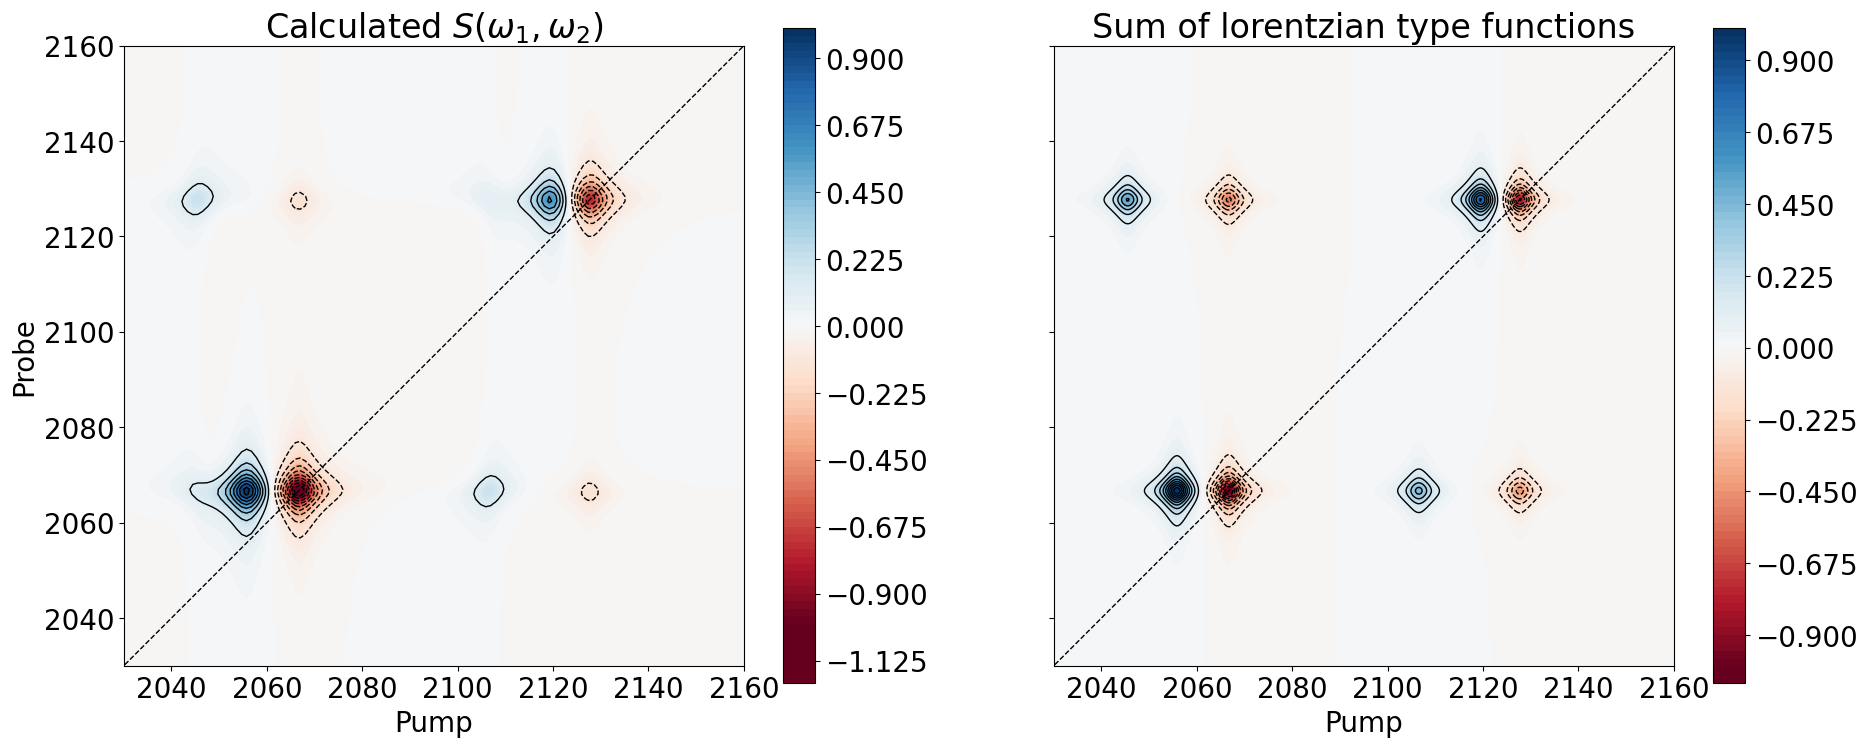

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(22,10))

ax1.plot([w.min(),w.max()], [w.min(),w.max()], ls="--", c="0")
ax2.plot([min_fd,max_fd], [min_fd,max_fd], ls="--", c="0")

im1 = ax1.contourf(w,w,S, 100, alpha=1, cmap='RdBu', vmax=1, vmin=-1)
im2 = ax2.contourf(x_2d_l,x_2d_l,z_2d_l, 100, alpha=1, cmap='RdBu', vmax=1, vmin=-1)

ax1.contour(w,w,S,spectra.set_line_spacing(abs(S).max(),10),colors='k')
ax2.contour(x_2d_l,x_2d_l,z_2d_l,spectra.set_line_spacing(abs(z_2d_l).max(),10),colors='k')

ax1.set_title('Calculated $S(\omega_1,\omega_2)$')
ax2.set_title('Sum of lorentzian type functions')

ax1.set_ylabel('Probe')
ax1.set_xlabel('Pump')
ax2.set_xlabel('Pump')

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

ax1.set_xlim(2030,2160)
ax1.set_ylim(2030,2160)

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

----------
## Time Domain Class

The `frequencydomain` class inherits the `Calc2dir_base` class.  
It also needs frequencies and dipole moments as input parameters. 

The time domain calculation needs more parameters:
- `n_t` : number of time points (grid)
- `dt` : spacing between time points
- `T2` : dephasing time
- `t2` : time between laser pulses
- `pol` : polarization condition, e.g. 'ZZZZ' or 'ZZXX'
- `pol_list` : polarization condition angles, e.g. [0,0,0,0] or [0,0,90,90]
- `omega_off` : roughly the median of fundamental frequencies

If none are given, the calculation automatically choses standard values.

```python
timedomain(VCI_freq,VCI_dipo,n_t=n_t,dt=dt,T2=T2,pol=pol,pol_list=pol_list,omega_off=omega_off,print_output=True)
```

All calculations can also be done for the harmonic spectra! (Which per se is possible, but useless, as all peaks cancel each other...)

The response functions are calculated using
```python
def calc_diagrams():
    ...
    return R1, R2, R3, R4, R5, R6
```
where `R1` and `R4` account for the stimulated emission, `R2` and `R5` account for the ground state bleaching and `R3` and `R6` accout for the excited state absorption.  
The resulting spectrum is generated by using
```python
def get_absorptive_spectrum():
    ...
    return R, axes
```
which returns the axes `axes` and the signal `R`.  
By treating the fourier-transformation in the `get_absorptive_spectrum` differently or using a different set of diagrams, one can vary the resulting plots. The following functions are implemented, but yet confirmed to work according to the theory: 
- `get_photon_echo_spectrum()`
- `get_correlation_spectrum()`

In [10]:
R, ticks = timedomain(VCI_freq,VCI_dipo).get_absorptive_spectrum()
R = R/R.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).


In [11]:
R_ZZXX, ticks_ZZXX = timedomain(VCI_freq,VCI_dipo,pol='ZZXX').get_absorptive_spectrum()
R_ZZXX = R_ZZXX/R_ZZXX.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZXX .
Set the polarization angles (pol_list) to [0, 0, 90, 90] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).


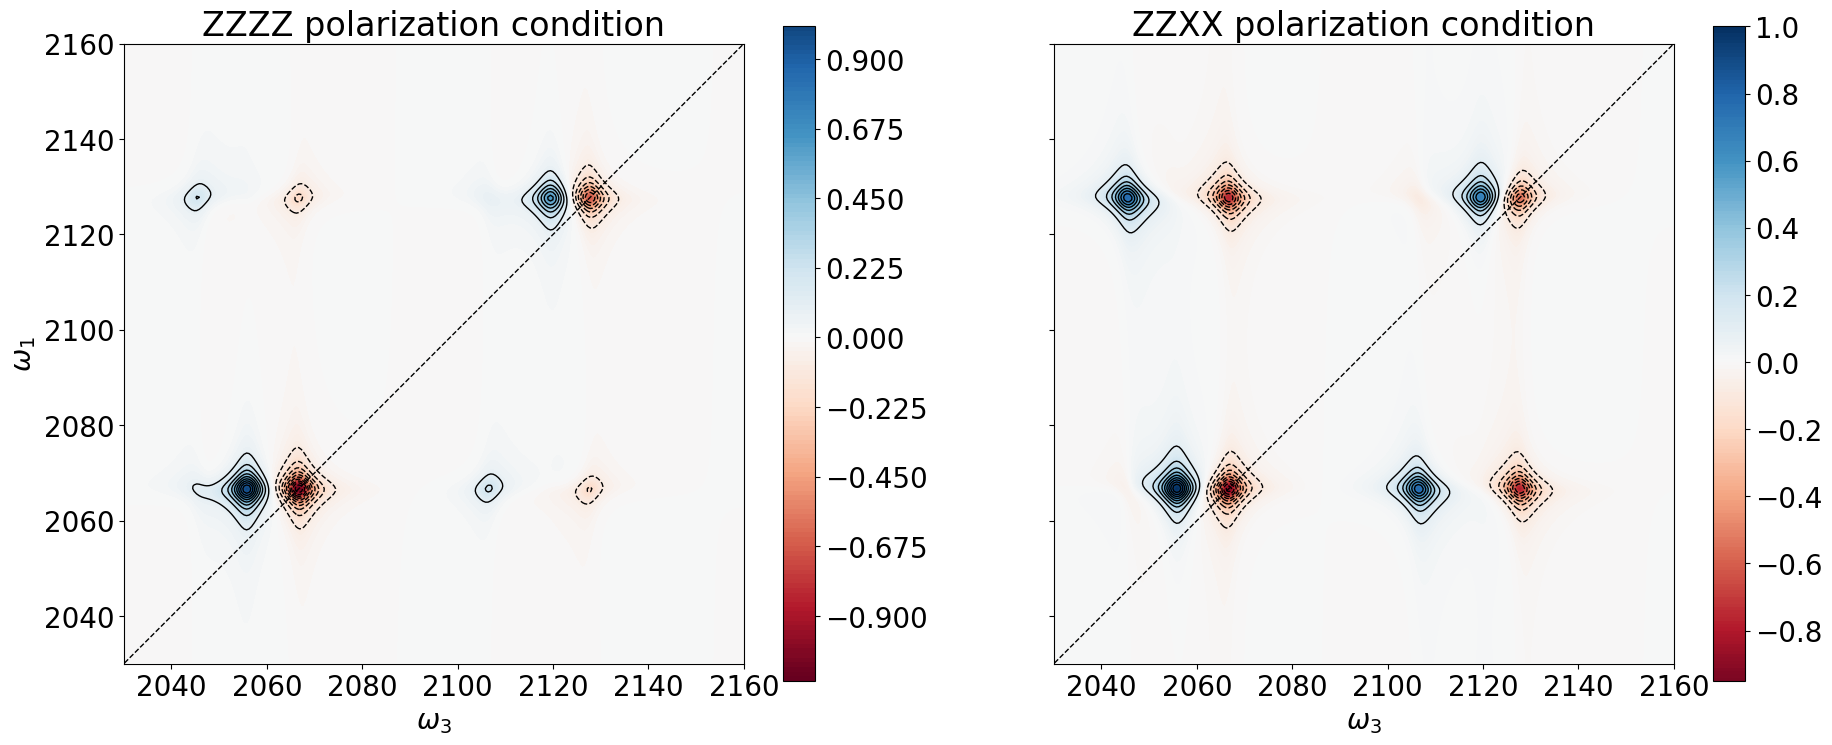

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(22,10))

ax1.plot([min(ticks),max(ticks)], [min(ticks),max(ticks)], ls="--", c="0")
ax2.plot([min(ticks_ZZXX),max(ticks_ZZXX)], [min(ticks_ZZXX),max(ticks_ZZXX)], ls="--", c="0")

im1 = ax1.contourf(ticks, ticks, R, 200, alpha=1, cmap='RdBu', vmax=abs(R).max(), vmin=-abs(R).max())
im2 = ax2.contourf(ticks_ZZXX, ticks_ZZXX, R_ZZXX, 200, alpha=1, cmap='RdBu', vmax=abs(R_ZZXX).max(), vmin=-abs(R_ZZXX).max())

ax1.contour(ticks, ticks, R, spectra.set_line_spacing(abs(R.max()),10), colors='k')
ax2.contour(ticks_ZZXX, ticks_ZZXX, R_ZZXX, spectra.set_line_spacing(abs(R_ZZXX).max(),10), colors='k')

ax1.set_title('ZZZZ polarization condition')
ax2.set_title('ZZXX polarization condition')

ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax2.set_xlabel('$\\omega_3$')

ax1.set_xlim(2030,2160)
ax1.set_ylim(2030,2160)

ax1.set_aspect(1./ax1.get_data_ratio())
ax2.set_aspect(1./ax2.get_data_ratio())

fig.colorbar(im1, ax=ax1, shrink=0.85)
fig.colorbar(im2, ax=ax2, shrink=0.85)

plt.show()

------------
## Exciton Model Class

The `excitonmodel` class inherits the `Calc2dir_base` class.  
It needs a coupling matrix `cmat` and dipoles `dipoles` from harmonic calculations as input.

It is used before the time or frequency model calculation and prepare the input frequencies and transition dipole moments using
```python 
def get_nm_freqs_dipolmat(anharm, shift='all'):
    ...
    return freqs_lm, dipole_nm
```
where `anharm` is the empirical parameter for the anharmonicity, `shift=all` applies the given anharmonicity to all elements on the diagonal of the constructed hamiltonian - the other option `exc2` only applies the anharmonicity to the doubly excited states in the two-exciton part of the hamiltonian.  
It returns new frequencies `freqs_lm` and dipole moments `dipole_nm`.

In [13]:
EX_freqs, EX_dipoles = excitonmodel(EXC_cmat, EXC_dipo).get_nm_freqs_dipolmat(20)

In [14]:
R_EX, ticks_EX = timedomain(EX_freqs,EX_dipoles).get_absorptive_spectrum()
R_EX = R_EX/R_EX.max()

freqdom_EX = frequencydomain(EX_freqs, EX_dipoles, T2=0.35)
x_EX_l, z_EX_l_ = freqdom_EX.get_2d_spectrum()
z_EX_l = z_EX_l_/z_EX_l_.max()

Prints all output (default). To suppress printed output use timedomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 128 (default value).
Set the time step length (dt) to 0.25 ps (default value).
Set the dephasing time (T2) to 2 ps (default value).
Set the population time (t2) to 0 ps (default value).
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).
Set the omega offset value (omega_off) to 2097 (calculated default).
Prints all output (default). To suppress printed output use frequencydomain(freqs,dipoles,print_output=False).
Set the number of time points (n_t) to 256 (default value).
Set the dephasing time (T2) to 0.35 ps.
Set the polarization (pol) to ZZZZ (default).
Set the polarization angles (pol_list) to [0, 0, 0, 0] (calculated default).


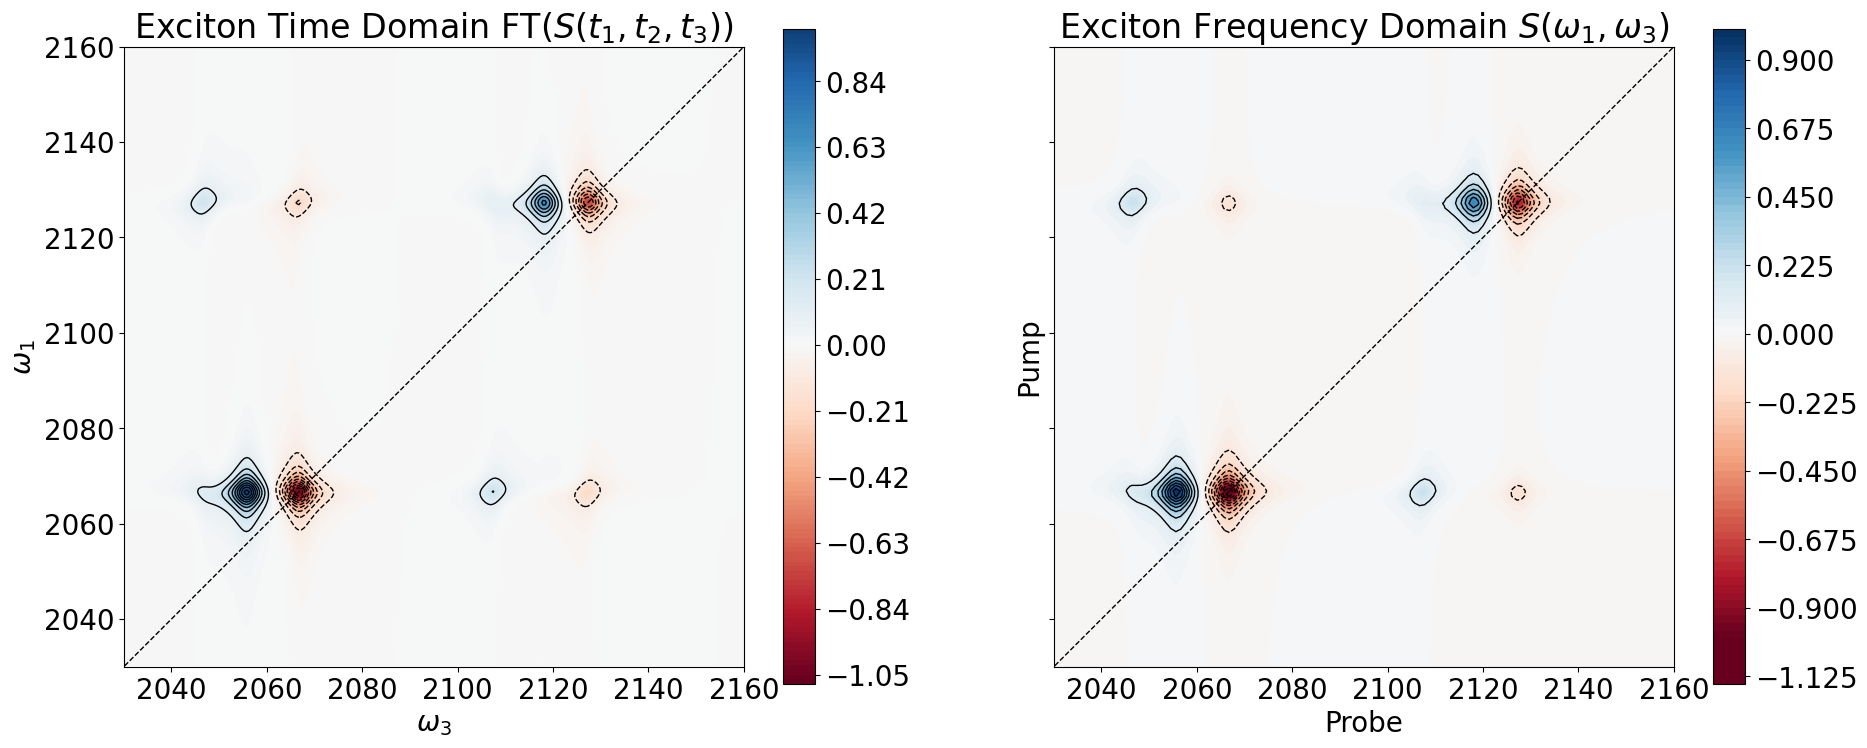

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(22,10))

ax1.plot([min(ticks_EX),max(ticks_EX)], [min(ticks_EX),max(ticks_EX)], ls="--", c="0")
im1 = ax1.contourf(ticks_EX, ticks_EX, R_EX, 200, alpha=1, cmap='RdBu', vmax=abs(R_EX).max(), vmin=-abs(R_EX).max())
ax1.contour(ticks_EX, ticks_EX, R_EX, spectra.set_line_spacing(abs(R_EX).max(),10), colors='k')

ax1.set_title('Exciton Time Domain FT$(S(t_1,t_2,t_3))$')
ax1.set_ylabel('$\\omega_1$')
ax1.set_xlabel('$\\omega_3$')
ax1.set_aspect(1./ax1.get_data_ratio())
fig.colorbar(im1, ax=ax1, shrink=0.85)


ax2.set_title('Exciton Frequency Domain $S(\omega_1,\omega_3)$')
ax2.plot([x_EX_l.min(),x_EX_l.max()], [x_EX_l.min(),x_EX_l.max()], ls="--", c="0")
im2 = ax2.contourf(x_EX_l,x_EX_l,z_EX_l, 100, alpha=1, cmap='RdBu', vmax=1, vmin=-1)
ax2.contour(x_EX_l,x_EX_l,z_EX_l,spectra.set_line_spacing(abs(z_EX_l).max(),10),colors='k')
ax2.set_ylabel('Pump')
ax2.set_xlabel('Probe')
ax2.set_aspect(1./ax2.get_data_ratio())
fig.colorbar(im2, ax=ax2, shrink=0.85)

ax1.set_xlim(2030,2160)
ax1.set_ylim(2030,2160)

plt.show()